<a href="https://colab.research.google.com/github/highbridge1029-glitch/guest/blob/master/machine_learning/cnn/cnn_cifar10_simple.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📷 画像分類：CNNによる特徴抽出と確率出力

前回のノートブックでは、4つの数値（特徴量）を入力として扱いました。今回は、 **画像（ピクセルデータの集合）** を入力とする「畳み込みニューラルネットワーク (CNN)」を扱います。

重要なポイントは以下の2点です。

1.  **入力** : 人間が計測した数値ではなく、画像データそのものを入力する。
2.  **出力** : 各クラスに属する「確率」が出力される。

---
### ⚙️ GPU ランタイムの確認
このプログラムは計算負荷が高いため、 **Google Colab を前提とし、GPU（グラフィックボード）を使用します。** メニューの「ランタイム」→「ランタイムのタイプを変更」から「T4 GPU」を選択してください。

設定できていない場合、以下のセルを実行するとエラーが発生して停止します。

In [1]:
import torch
import sys

# GPUが使用可能か確認する
if not torch.cuda.is_available():
    # GPUが使えない場合は、意図的にエラーを発生させて停止させる
    raise RuntimeError(
        "❌ GPUが検出されませんでした。\n"
        "メニューバーの「ランタイム」>「ランタイムのタイプを変更」から\n"
        "「T4 GPU」などを選択して保存し、再実行してください。"
    )

print(f"✅ GPUが正常に検出されました: {torch.cuda.get_device_name(0)}")
device = torch.device("cuda:0")

# 必要なライブラリのインポート
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

✅ GPUが正常に検出されました: Tesla T4


## 🖼️ 1. データセットの確認

モデルを構築する前に、今回使用するデータセット **CIFAR-10** の中身を確認します。
これは以下の10クラスの画像が含まれています。

* `plane` (飛行機), `car` (自動車), `bird` (鳥), `cat` (猫), `deer` (鹿)
* `dog` (犬), `frog` (カエル), `horse` (馬), `ship` (船), `truck` (トラック)

画像は $32 \times 32$ ピクセルのカラー画像です。

100%|██████████| 170M/170M [00:40<00:00, 4.18MB/s]


--- CIFAR-10 データセットのサンプル (50000枚から抜粋) ---


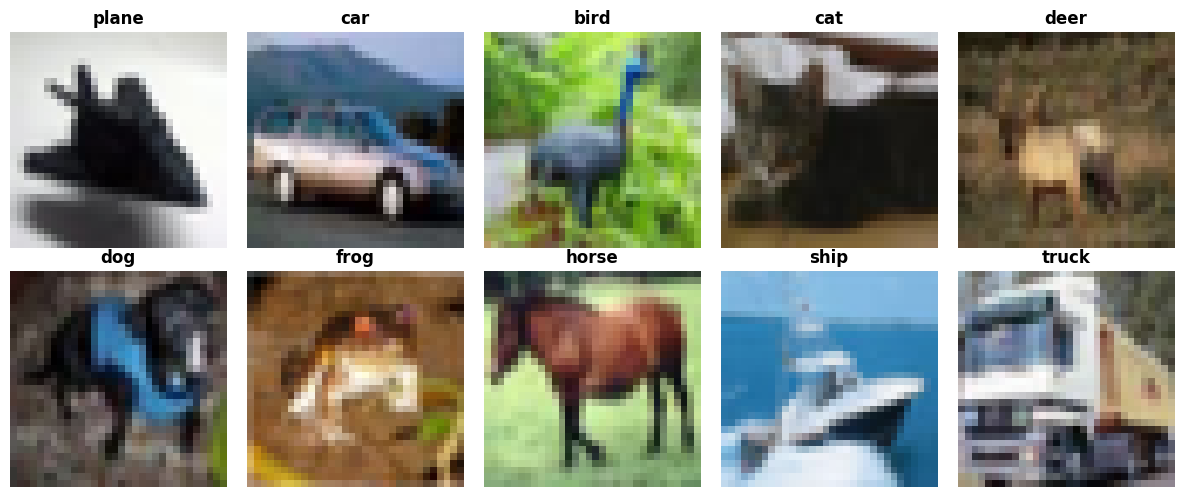

In [2]:
#@title データのダウンロードと各クラスの表示
# 前処理の定義（テンソル化と正規化）
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# 学習用データのダウンロードとロード
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# テスト用データのダウンロードとロード
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=2)

# クラス名の定義
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# 画像表示用の関数
def imshow(img, ax):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.numpy()
    ax.imshow(np.transpose(npimg, (1, 2, 0)))
    ax.axis('off')

# 各クラスの画像を1枚ずつ取得して表示
class_images = {}
dataiter = iter(trainset)

# 10クラス揃うまで画像を探索
while len(class_images) < 10:
    image, label = next(dataiter)
    label_name = classes[label]
    if label_name not in class_images:
        class_images[label_name] = image

# 表示
print(f"--- CIFAR-10 データセットのサンプル ({len(trainset)}枚から抜粋) ---")
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
axes = axes.flatten()

for i, class_name in enumerate(classes):
    imshow(class_images[class_name], axes[i])
    axes[i].set_title(class_name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

# データローダーの準備（学習用）
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# 📝 課題：前回 (Iris) と今回 (CIFAR-10) の比較

前回の講義で扱った「アヤメ (Iris) の分類」と、今回の「画像 (CIFAR-10) の分類」について、入力と出力の違いを整理しましょう。以下の表の空欄を埋めながら、違いを確認してください。

| 項目 | 前回: Iris (アヤメ) | 今回: CIFAR-10 (画像) |
| :--- | :--- | :--- |
| **1. 入力データ** | 人間が計測した **【特徴量】** <br> (例：がくの長さ、幅など **4** つの数値) | カメラが撮影した **【濃度値】** <br> (例：$32 \times 32$ ピクセル $\times$ RGB 3色 ＝ **3072** 個の数値) |
| **入力データの意味** | 数値そのものに意味がある <br> (大きい＝長い、など) | **個々の画素値に特定の意味はない** <br> (隣り合う画素との関係性が重要) |
| **2. 出力データ** | **3** つのクラスごとの確率 | **【１０】** 個のクラスごとの確率 |

---

## ⚙️ 2. モデルの構築と学習

画像分類を行う **CNN (Convolutional Neural Network)** モデルを定義し、学習を行います。

### モデルの役割
このモデルは、入力された画像データ $x$ に対し、一連の計算処理を行い、最終的に10個の数値（確率の元となるスコア）を出力します。

1.  **特徴抽出 (Convolution)** : 画像からエッジや模様などの特徴を自動的に検出します。
2.  **分類 (Linear)** : 検出された特徴に基づき、どのクラスに属するかを計算します。

※以下のセルを実行すると学習が始まります（数分かかります）。

In [3]:
#@title モデル定義と学習実行
# シンプルなCNNモデルの定義
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        # 特徴抽出層 (畳み込み層 + プーリング層)
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1), nn.ReLU(), nn.MaxPool2d(2, 2)
        )
        # 分類層 (全結合層)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 512), nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# モデルをGPUに転送
net = SimpleCNN().to(device)

# 損失関数と最適化手法の定義
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# 学習ループ
epochs = 5
print(f"🚀 学習を開始します (全 {epochs} エポック)...")

for epoch in range(epochs):
    net.train() # 学習モード
    running_loss = 0.0
    # tqdmで進捗バーを表示
    with tqdm(trainloader, unit="batch") as tepoch:
        for data in tepoch:
            tepoch.set_description(f"Epoch {epoch+1}")

            inputs, labels = data[0].to(device), data[1].to(device)

            optimizer.zero_grad()       # 勾配の初期化
            outputs = net(inputs)       # 推論
            loss = criterion(outputs, labels) # 損失の計算
            loss.backward()             # 逆伝播
            optimizer.step()            # パラメータ更新

            tepoch.set_postfix(loss=loss.item())

print("✅ 学習が完了しました。")

🚀 学習を開始します (全 5 エポック)...


Epoch 5: 100%|██████████| 12500/12500 [01:39<00:00, 125.14batch/s, loss=0.197]

✅ 学習が完了しました。


## 🧪 3. 推論結果の可視化

学習済みモデルを用いて、テストデータ（学習には使用していない画像）の分類を行います。

以下のフォームで画像IDを指定すると、モデルに入力画像を与え、その出力結果（確率分布）を表示します。
モデルが **「どのクラスだと判断したか」** **「その判断にどれくらいの確信度（確率）を持っているか」** を確認してください。

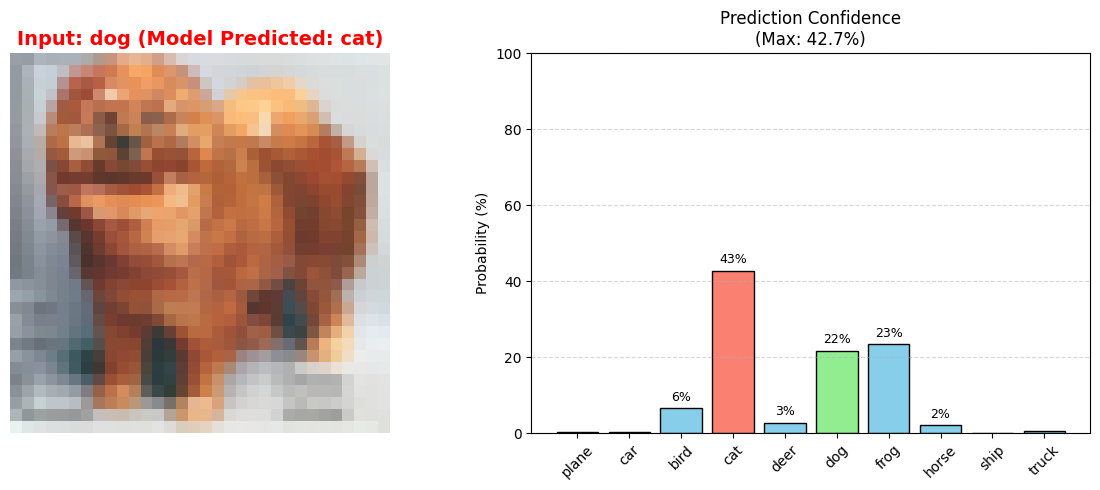

正解クラス: dog
モデル判定: 不正解 (42.7% の確率で cat と予測)


In [11]:
#@title 🔍 テスト画像の判定
#@markdown 画像IDを選択してください

image_id = 4005 # @param {"type":"slider","min":0,"max":9999,"step":1}

def imshow(img):
    img = img / 2 + 0.5     # 正規化を戻す
    npimg = img.cpu().numpy() # GPUにある場合はCPUに戻す
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis('off')

# 指定されたIDの画像を取得
test_data_iter = iter(testloader)
# image_idの数だけスキップ（簡易実装）
for _ in range(image_id):
    try:
        next(test_data_iter)
    except StopIteration:
        print("画像IDが範囲外です。最初に戻ります。")
        test_data_iter = iter(testloader)
        break

images, labels = next(test_data_iter)

# モデルによる推論
net.eval() # 評価モード
with torch.no_grad():
    images_gpu = images.to(device)
    outputs = net(images_gpu)
    # ソフトマックス関数で確率に変換
    probs = F.softmax(outputs, dim=1)
    # CPUに戻してNumPy配列化
    probs_np = probs.cpu().numpy()[0] * 100

# 結果の取得
prediction_idx = torch.argmax(probs, dim=1).item()
true_label_idx = labels.item()
prediction_name = classes[prediction_idx]
true_label_name = classes[true_label_idx]

# --- 可視化 ---
plt.figure(figsize=(12, 5))

# 1. 入力画像の表示
plt.subplot(1, 2, 1)
imshow(images[0])  # ここで修正した関数を使用
title_text = f"Input: {true_label_name}"
title_color = "black"
if prediction_idx != true_label_idx:
    title_text += f" (Model Predicted: {prediction_name})"
    title_color = "red"
plt.title(title_text, fontsize=14, color=title_color, fontweight='bold')

# 2. 確率分布の表示
plt.subplot(1, 2, 2)
colors = ['skyblue'] * 10
# 正解のバーを緑、間違った予測のバーを赤にする
colors[true_label_idx] = 'lightgreen'
if prediction_idx != true_label_idx:
    colors[prediction_idx] = 'salmon'

bars = plt.bar(classes, probs_np, color=colors, edgecolor='black')
plt.ylabel('Probability (%)')
plt.title(f'Prediction Confidence\n(Max: {probs_np[prediction_idx]:.1f}%)', fontsize=12)
plt.ylim(0, 100)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.5)

# 確率値の表示
for bar, p in zip(bars, probs_np):
    if p > 1.0: # 1%以上のみ表示
        plt.text(bar.get_x() + bar.get_width()/2, p + 2, f"{p:.0f}%", ha='center', fontsize=9)

plt.tight_layout()
plt.show()

# テキスト出力
print(f"正解クラス: {true_label_name}")
if prediction_idx == true_label_idx:
    print(f"モデル判定: 正解 ({probs_np[prediction_idx]:.1f}% の確率で {prediction_name} と予測)")
else:
    print(f"モデル判定: 不正解 ({probs_np[prediction_idx]:.1f}% の確率で {prediction_name} と予測)")

# 📝 課題：モデルの出力特性を分析する

上の実験コードで `image_id` を変更し、以下のケースに該当する画像の番号（ID）を探してください。

#### 1. 高い確信度での正解
モデルが90%以上の確率を出して正解した画像のIDを1つ挙げてください。
* **画像ID** : [1404]
* **クラス** : [car]
* **考察** : なぜモデルはこの画像の分類が容易だったと考えられますか？（例：背景、形状の特徴など）
    * [ 境界線がはっきりとしている ]

#### 2. 低い確信度、または誤分類
確率が低い、複数のクラスで確率が分散している、あるいは誤分類した画像のIDを1つ挙げてください。
* **画像ID** : [ 4005 ]
* **モデルの予測** : [ cat ]  （正解は：[ dog ]）
* **考察** : なぜモデルは分類に失敗した、あるいは確信を持てなかったと考えられますか？
    * [ 耳の形があまり見えない ]

# 📝 復習課題：間違いだらけのレポート修正

ある学生が、今回の実験（画像分類AI）についてレポートを書きましたが、**入力と出力に関して大きな勘違い**をしているようです。
以下の文章には **3つの間違い** があります。どこが間違っているか指摘し、正しい説明に直してください。

---

### ❌ 間違いだらけのレポート

「今回扱った画像認識AI（CNN）は、人間と同じように画像を見るすごいモデルです。

まず入力として、私たちは画像の中に写っている **『耳が尖っている』や『尻尾が長い』といった特徴を言葉や数値にして** AIに教えました（①）。

AIの内部で計算が行われた後、出力層からは **『猫』という正解のクラス名（文字）** が出力されました（②）。

この出力を見ることで、AIがどれくらい自信を持っているかが分かります。なぜなら、出力された数値の合計は **特に決まっていない（100%にならない）** からです（③）。」

---

### ✅ あなたの修正案

**① 入力について**
* **誤**: 『耳が尖っている』などの特徴を入力した
* **正**: AIに入力したのは、カメラで撮ったままの **【画像】** です。（ヒント：3072個の数値）

**② 出力について**
* **誤**: 『猫』というクラス名だけが出力された
* **正**: 実際には、10個のクラスそれぞれの **【確率】** が出力されました。私たちはその中から最大のものを選んでいます。

**③ 確率のルール**
* **誤**: 合計は決まっていない
* **正**: 全てのクラスの確率を足すと必ず **【１】** になるようになっています。